In [1]:
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

Obtaining MI_prediction from git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction
  Updating ./src/mi-prediction clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 98db61ef89123c7cccd10cc68e4948121882119d
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MI_prediction
    Found existing installation: MI-prediction 0.1
    Uninstalling MI-prediction-0.1:
      Successfully uninstalled MI-prediction-0.1
  Running setup.py develop for MI_prediction
Note: you may need to restart the kernel to use updated packages.


In [136]:
from MI_prediction.Utils.Datasets import  DataLoader_Rest, get_epochs, get_runs, get_labels
from MI_prediction.Datasets import Cho2017_Rest, BNCI2014001_Rest
from MI_prediction.Utils.Preprocess import filterbank_preprocessor, filterbank, FBCSP, moments, scaler_list
from MI_prediction.Utils.Windowers import create_windows
from MI_prediction.Utils.Datautils import features_by_channels
from MI_prediction.Models import DLSMR
from braindecode.preprocessing.preprocess import exponential_moving_standardize, preprocess, Preprocessor, scale
from scikeras.wrappers import KerasRegressor 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV,LeaveOneOut,cross_val_predict

from sklearn.preprocessing import StandardScaler
from mne.preprocessing import compute_current_source_density
import tensorflow as tf

from MI_prediction.Utils.Wrappers import MultiInputRegressor, MultiInputScaler

import time
import pickle

# GIGAScience Cho2017

In [2]:
dl = DataLoader_Rest(dataset_name=Cho2017_Rest())

subjects = np.arange(1,53)
subjects = subjects[(subjects!=32) & (subjects!=46) & (subjects!=49)]

duration=66

## Preprocessing

### For moments

In [4]:
fb = filterbank_preprocessor([(8.,15.),(15.,25.)], method='iir',iir_params={'order':5,'ftype':'butter'})

preprocessors_mts = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor('pick_channels', ch_names=['C3', 'C4', 'Cz', 'P3', 'P4', 'Pz']),  # Keep only EEG channels
        Preprocessor(scale, factor=1e3, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=1., h_freq=None, method='iir',iir_params={'order':5,'ftype':'butter'})
        ]

Ch_prep = [
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

st_offsets_mts, ed_offsets_mts = create_windows(win = 2, start_offset = 5, end_offset = -6, mi_duration = duration, overlap = 0.5)

band to filter: (8.0, 15.0) Hz
band to filter: (15.0, 25.0) Hz


### For PSD

In [5]:
preprocessors_psd = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor('pick_channels', ch_names=['C3', 'C4', 'Cz', 'P3', 'P4', 'Pz']), 
        Preprocessor(scale, factor=1e3, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=8., h_freq=30., method='iir',iir_params={'order':5,'ftype':'butter'}),
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]
st_offsets_psd, ed_offsets_psd = create_windows(win = 55, start_offset = 5, end_offset = -6, mi_duration = duration, overlap = 0)

## Feature extraction

In [6]:
Epochs_mts = []
Epochs_psd = []

for s in subjects:
    print ("Subject: {}".format(s))
    tic = time.time()

    dl.load_data(subject_ids=[s])

    ds_f = filterbank(dl, preprocess=preprocessors_mts, filters=fb, channels_prep=Ch_prep)
    trials = [tr.get_trials(start_offset=st_offsets_mts, end_offset=ed_offsets_mts) for tr in ds_f]

    epochs_mts = []
    for nw in trials[0].keys():
        epochs_mts.append(np.concatenate([np.expand_dims(moments(get_epochs(epoch[nw].split('session')['session_0'])),axis=3) for epoch in trials],axis=-1))

    Epochs_mts.append(np.concatenate(epochs_mts, axis=2))

    fs = dl.dataset.datasets[0].raw.info['sfreq']

    dl.preprocess_data(preprocessors=preprocessors_psd)
    trials_psd = dl.get_trials(start_offset=st_offsets_psd, end_offset=ed_offsets_psd)

    Epochs_psd.append(welch(get_epochs(trials_psd['win_0'])[0],fs=fs,nperseg=int(2*fs))[-1])

    print("Elapsed: {}".format(time.time()-tic))

Epochs_mts = np.concatenate(Epochs_mts, axis=0)
Epochs_psd = np.concatenate(Epochs_psd, axis=0)

save_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Data/GIGA/2Class/'

Epochs_rest = {
    'Subjects': subjects,
    'Epochs_mts': Epochs_mts,
    'Epochs_psd': Epochs_psd
    }
pickle.dump(Epochs_rest, open(save_path+'Epochs_rest.pkl', 'wb'))

Subject: 1
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-b

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.168879270553589
Subject: 2
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 p

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3987700939178467
Subject: 3
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching event

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.242453098297119
Subject: 4
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.256833791732788
Subject: 5
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epoch

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.143902063369751
Subject: 6
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from pr

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.248103141784668
Subject: 7
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3635990619659424
Subject: 10
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 pr

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1804909706115723
Subject: 11
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original tim

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.108842134475708
Subject: 12
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2289106845855713
Subject: 13
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.073723316192627
Subject: 14
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1335649490356445
Subject: 15
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.311601161956787
Subject: 16
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3312389850616455
Subject: 18
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using dat

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1904702186584473
Subject: 19
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2608282566070557
Subject: 20
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original tim

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.162609100341797
Subject: 21
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3053488731384277
Subject: 22
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3897390365600586
Subject: 23
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2626140117645264
Subject: 24
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2121529579162598
Subject: 25
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1781821250915527
Subject: 26
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.13273024559021
Subject: 27
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from pre

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1247119903564453
Subject: 28
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2856152057647705
Subject: 29
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3311948776245117
Subject: 30
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.28364896774292
Subject: 31
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2716379165649414
Subject: 33
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data f

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.264150619506836
Subject: 34
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


0 bad epochs dropped
Elapsed: 3.3157413005828857
Subject: 35
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.0991220474243164
Subject: 36
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.223177909851074
Subject: 37
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.085326910018921
Subject: 38
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data f

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 event

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.248296022415161
Subject: 40
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1800620555877686
Subject: 41
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching event

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.227212905883789
Subject: 42
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.135699987411499
Subject: 43
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2710659503936768
Subject: 44
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using dat

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1414358615875244
Subject: 45
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.32149600982666
Subject: 47
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2006068229675293
Subject: 48
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2532591819763184
Subject: 51
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2577033042907715
Subject: 52
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1277997493743896


In [12]:
Epochs_rest.keys()

dict_keys(['Subjects', 'Epochs_mts', 'Epochs_psd'])

## Training

### Load and organize data

In [2]:
load_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Data/GIGA/2Class/'
load_label_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Results/GIGA/2Class/'

In [3]:
data = pickle.load(open(load_path+'Epochs_rest.pkl', 'rb'))

In [4]:
data.keys()

dict_keys(['Subjects', 'Epochs_mts', 'Epochs_psd'])

In [119]:
X = []
for i in range(data['Epochs_mts'].shape[-1]):
    X+=features_by_channels(data['Epochs_mts'][:,:,:,i])[0:2] # for C3 and C4
X+=features_by_channels(data['Epochs_psd'])[0:2]# for C3 and C4

labels = pickle.load(open(load_label_path+'acc_train.pkl', 'rb'))

In [141]:
sc = MultiInputScaler(scaler=StandardScaler(), input_feats=[x.shape[-1] for x in X], keep_dims=True)
X_train = sc.fit_transform(np.concatenate(X,axis=-1))

### multiple input scikit-learn

In [140]:
m = MultiInputRegressor(model=DLSMR,loss=tf.keras.losses.mae,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    epochs=200,batch_size=30,validation_split=0.1,
                    input_feats = [x.shape[-1] for x in X]
                    )

In [127]:
scy = StandardScaler()
yy = scy.fit_transform(np.asarray(labels['0.5']).reshape(-1, 1)).ravel()

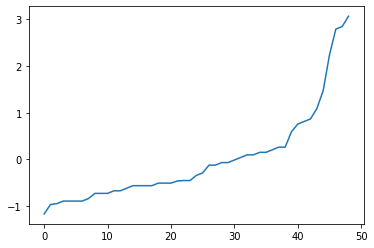

In [128]:
plt.plot(np.sort(yy))
plt.show()

In [144]:
reg = Pipeline([('scaler', sc), ('regressor', m)])
reg = cross_val_predict(estimator=reg,X=np.concatenate(X,axis=-1),y=yy,cv=LeaveOneOut())

TypeError: 'Pipeline' object is not callable

In [143]:
np.concatenate(X,axis=-1).shape

(49, 2106)

In [129]:
m.fit(X=X_train,y=yy)

Epoch 1/200


2022-08-13 00:32:13.651880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 139.9960

2022-08-13 00:32:14.749182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 851ms/step - loss: 139.9960 - val_loss: 138.5662
Epoch 2/200
2/2 [==============================] - 0s 158ms/step - loss: 139.1224 - val_loss: 133.2187
Epoch 3/200
2/2 [==============================] - 0s 134ms/step - loss: 131.6415 - val_loss: 124.8201
Epoch 4/200
2/2 [==============================] - 0s 104ms/step - loss: 124.7219 - val_loss: 118.6445
Epoch 5/200
2/2 [==============================] - 0s 136ms/step - loss: 119.1708 - val_loss: 114.5006
Epoch 6/200
2/2 [==============================] - 0s 89ms/step - loss: 114.3869 - val_loss: 110.7822
Epoch 7/200
2/2 [==============================] - 0s 64ms/step - loss: 110.6913 - val_loss: 106.3511
Epoch 8/200
2/2 [==============================] - 0s 86ms/step - loss: 105.9646 - val_loss: 103.0554
Epoch 9/200
2/2 [==============================] - 0s 97ms/step - loss: 102.2669 - val_loss: 98.8537
Epoch 10/200
2/2 [==============================] - 0s 54ms/step - loss: 97.9079 - val_los

MultiInputRegressor(
	model=<function DLSMR at 0x28af13ca0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x539ae06a0>
	loss=<function mean_absolute_error at 0x29a5fee50>
	metrics=None
	batch_size=30
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=200
	input_feats=[270, 270, 270, 270, 513, 513]
)

### inference

In [130]:
ypred = m.predict(X_train)

2/2 [==============================] - 0s 76ms/step


2022-08-13 00:32:32.827957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [131]:
ypred

array([ 0.14305042, -1.1491104 ,  2.8517075 , -0.77144814,  0.19938773,
        0.8946407 , -0.9868612 ,  0.21256281, -0.38685295, -0.04464558,
       -0.9180424 , -0.30114815,  0.42877308,  2.9372675 , -0.7292096 ,
       -0.46905586, -0.90117925, -0.92258877,  0.1573203 , -0.9205217 ,
       -0.09722863, -0.6551497 ,  0.13104162, -0.5762802 , -0.6616269 ,
        0.3331498 , -0.00462007, -0.02571056, -0.6809257 , -0.5656171 ,
       -0.4819931 , -1.075372  , -0.22280242,  2.3070672 , -0.3870534 ,
        1.1298465 , -0.62613356,  0.6879771 , -0.6591824 ,  0.04721881,
       -0.40978923,  3.12134   ,  0.8650421 , -0.71327114,  0.21054716,
        0.5764568 ,  0.38416505,  0.43075034,  1.5893216 ], dtype=float32)

In [132]:
from sklearn.metrics import r2_score

In [135]:
np.sqrt(r2_score(ypred.ravel(),yy))

0.9169244618751279

In [134]:
np.asarray(labels['3.0'])

array([0.715     , 0.51      , 0.815     , 0.595     , 0.72      ,
       0.775     , 0.48333333, 0.495     , 0.53333333, 0.59      ,
       0.515     , 0.54      , 0.635     , 0.87      , 0.485     ,
       0.535     , 0.515     , 0.53      , 0.59      , 0.53      ,
       0.695     , 0.52      , 0.685     , 0.49      , 0.54      ,
       0.62      , 0.56      , 0.585     , 0.545     , 0.52      ,
       0.615     , 0.525     , 0.55      , 0.81      , 0.515     ,
       0.7       , 0.55      , 0.58      , 0.51      , 0.545     ,
       0.555     , 0.955     , 0.645     , 0.57      , 0.555     ,
       0.68      , 0.845     , 0.51      , 0.54      ])